In [10]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_curve, auc, top_k_accuracy_score


In [ ]:
# Load metadata from CSV and construct file paths
csv_path = "/home/jecroisp/Thesis/FerLLMs-Emotional-Transition-Detection-in-GIFs/p_crema/GIF_Annotations.csv"
gif_folder = "/home/jecroisp/Thesis/FerLLMs-Emotional-Transition-Detection-in-GIFs/p_crema/CremaGifs"

metadata = pd.read_csv(csv_path)
metadata['GIF_Path'] = metadata['fileName'].apply(lambda x: os.path.join(gif_folder, f"{x}.gif"))
metadata = metadata[metadata['GIF_Path'].apply(os.path.exists)].reset_index(drop=True)

emotion_mapping = {"A": 0, "D": 1, "F": 2, "H": 3, "N": 4, "S": 5}
metadata['Emotion_Label'] = metadata['emoVote'].map(emotion_mapping)

# Filter out low-agreement samples (agreement >= 0.6)
metadata = metadata[metadata['agreement'] >= 0.6].reset_index(drop=True)

print(f"Number of samples in test set: {len(metadata)}")

Number of samples in test set: 14815


In [12]:
# Import Vision Transformer
from torchvision.models import vit_b_16, ViT_B_16_Weights  # ViT model and pre-trained weights

In [13]:
# Initialize a pre-trained Vision Transformer model
class EmotionRecognitionViT(nn.Module):
    def __init__(self, num_classes=6):
        super(EmotionRecognitionViT, self).__init__()
        # Load the pre-trained Vision Transformer
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        
        # Replace the classifier head with one suitable for our task
        in_features = self.vit.heads[0].in_features  # Access the input features of the last layer
        self.vit.heads = nn.Sequential(nn.Linear(in_features, num_classes))

    def forward(self, x):
        return self.vit(x)

# Initialize the ViT model
model = EmotionRecognitionViT(num_classes=6)


In [ ]:
#Load Model weights
model_path = "/home/jecroisp/Thesis/FerLLMs-Emotional-Transition-Detection-in-GIFs/p_crema/emotion_recognition_vit.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionRecognitionViT(num_classes=6)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_231188/2892068076.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


EmotionRecognitionViT(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln

In [15]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [16]:
class TestGIFDataset(Dataset):
    def __init__(self, metadata, transform=None, max_frames=10):
        self.metadata = metadata
        self.transform = transform
        self.max_frames = max_frames

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        gif_path = self.metadata.loc[idx, 'GIF_Path']
        label = self.metadata.loc[idx, 'Emotion_Label']

        # Load GIF as a sequence of frames
        gif = Image.open(gif_path)
        frames = []
        try:
            while True:
                frame = gif.copy().convert("RGB")
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
                gif.seek(gif.tell() + 1)
        except EOFError:
            pass

        # If too many frames, sample evenly
        if len(frames) > self.max_frames:
            indices = torch.linspace(0, len(frames) - 1, self.max_frames).long()
            frames = [frames[i] for i in indices]

        # Aggregate frames (e.g., average pooling across frames)
        frames_tensor = torch.stack(frames, dim=0)  # Shape: [num_frames, channels, height, width]
        aggregated_tensor = frames_tensor.mean(dim=0)  # Shape: [channels, height, width]

        return aggregated_tensor, label

In [18]:
# Create the dataset and data loader.
test_dataset = TestGIFDataset(metadata, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [19]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

In [20]:
# Classification Report
report = classification_report(all_labels, all_preds, target_names=['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       Anger       0.95      0.88      0.92      2238
     Disgust       0.77      0.96      0.85      1716
        Fear       0.87      0.87      0.87      1621
   Happiness       0.83      0.99      0.90      2600
     Neutral       0.93      0.84      0.88      5713
     Sadness       0.86      0.66      0.74       927

    accuracy                           0.88     14815
   macro avg       0.87      0.87      0.86     14815
weighted avg       0.88      0.88      0.88     14815



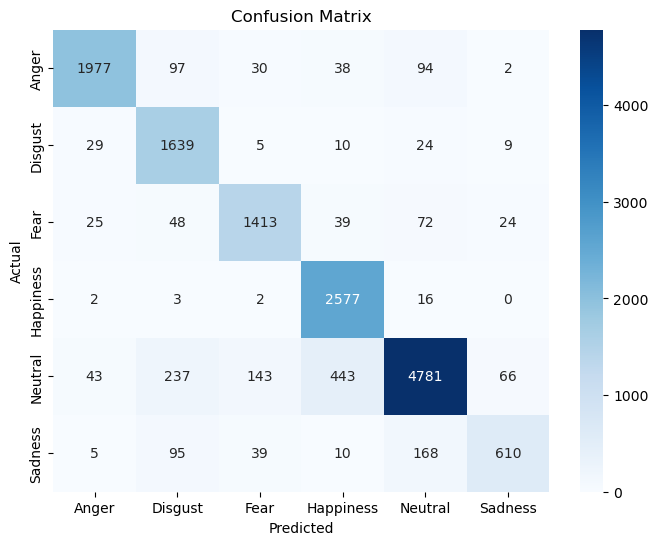

In [21]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'],
            yticklabels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Cohen's Kappa
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.84


In [23]:
# Top-K Accuracy (Top-1 and Top-3)
top1_acc = top_k_accuracy_score(all_labels, all_probs, k=1)
top3_acc = top_k_accuracy_score(all_labels, all_probs, k=3)
print(f"Top-1 Accuracy: {top1_acc:.2f}")
print(f"Top-3 Accuracy: {top3_acc:.2f}")

Top-1 Accuracy: 0.88
Top-3 Accuracy: 1.00


In [24]:
# ROC Curves and AUC (One-vs-Rest)
from sklearn.preprocessing import label_binarize

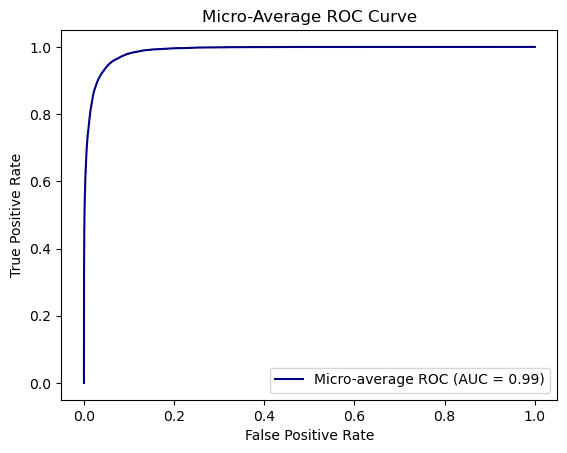

In [25]:
n_classes = 6
labels_binarized = label_binarize(all_labels, classes=range(n_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(labels_binarized.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure()
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve')
plt.legend(loc="lower right")
plt.show()